In [8]:
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from keras.utils import ImageDataGenerator

# ------------------------------------------------------1. 定义卷积基并配置微调------------------------------------------------------
local_weights_path = r'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
conv_base = VGG16(
    weights=local_weights_path,
    include_top=False,
    input_shape=(150, 150, 3)
)
# ------------------------------------------------------配置数据生成器（直接读取原始图像）---------------------------------------
train_dir = r"C:\Users\Administrator\PycharmProjects\深度学习日常练习项目\python深度学习红书\深度学习用于计算机视觉\猫狗分类模型\猫狗数据集\dataset\train"
validation_dir = r"C:\Users\Administrator\PycharmProjects\深度学习日常练习项目\python深度学习红书\深度学习用于计算机视觉\猫狗分类模型\猫狗数据集\dataset\validation"
test_dir = r"C:\Users\Administrator\PycharmProjects\深度学习日常练习项目\python深度学习红书\深度学习用于计算机视觉\猫狗分类模型\猫狗数据集\dataset\test"

# 训练集：加入数据增强（提升泛化能力）
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# 验证/测试集：仅归一化（不增强）
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 训练集生成器
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # 匹配模型输入
    batch_size=32,
    class_mode='binary'
)

# 验证集生成器
validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# 冻结卷积基的底层，仅解冻顶层（block5_conv1及之后）
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":  # 从block5_conv1开始解冻
        set_trainable = True
    layer.trainable = set_trainable  # True=可微调，False=冻结

# ------------------------------------------------------构建完整端到端模型-------------------------------
model = models.Sequential()
model.add(conv_base)  # 加入卷积基（输出(None,4,4,512)）
model.add(layers.Flatten())  # 展平：(None,4,4,512) → (None, 8192)
model.add(layers.Dense(256, activation='relu'))  # 全连接层（无需定义input_dim，自动匹配Flatten输出）
model.add(layers.Dropout(0.5))  # 防止过拟合
model.add(layers.Dense(1, activation='sigmoid'))  # 二分类输出

# ------------------------------------------------------编译与训练模型----------------------------------------------
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),  # 微调用小学习率
    loss="binary_crossentropy",
    metrics=['accuracy']
)
history = model.fit(
    train_generator,
    steps_per_epoch=10000 // 32,  # 训练集总样本数//批次大小
    epochs=100,
    validation_data=validation_generator,
    validation_steps=2500 // 32,  # 验证集总样本数//批次大小
    #callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/100
312/312 [==============================] - 31s 98ms/step - loss: 0.4676 - accuracy: 0.7636 - val_loss: 0.2498 - val_accuracy: 0.8946
Epoch 2/100
312/312 [==============================] - 31s 98ms/step - loss: 0.3201 - accuracy: 0.8630 - val_loss: 0.1895 - val_accuracy: 0.9187
Epoch 3/100
312/312 [==============================] - 30s 97ms/step - loss: 0.2792 - accuracy: 0.8801 - val_loss: 0.1774 - val_accuracy: 0.9283
Epoch 4/100
312/312 [==============================] - 30s 97ms/step - loss: 0.2415 - accuracy: 0.8975 - val_loss: 0.2076 - val_accuracy: 0.9139
Epoch 5/100
312/312 [==============================] - 31s 99ms/step - loss: 0.2340 - accuracy: 0.9010 - val_loss: 0.1483 - val_accuracy: 0.9379
Epoch 6/100
312/312 [==============================] - 35s 111ms/step - loss: 0.2186 - accuracy: 0.9104 - val_loss: 0.1470 - val_accuracy: 0.9415
Epoch 7/100
312/312 [=======================

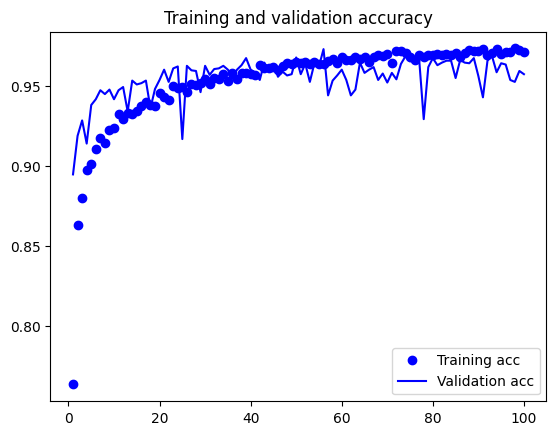

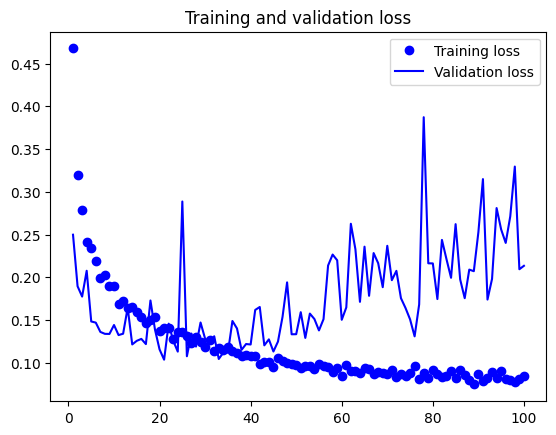

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


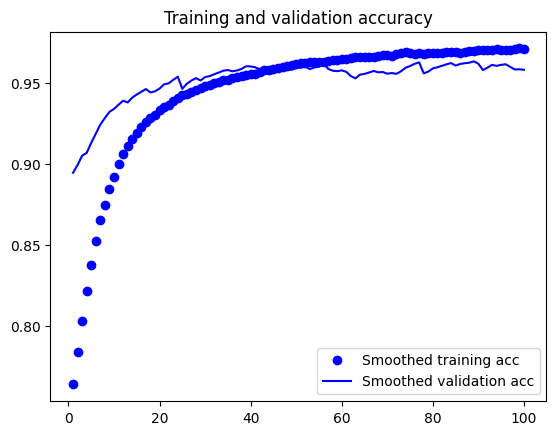

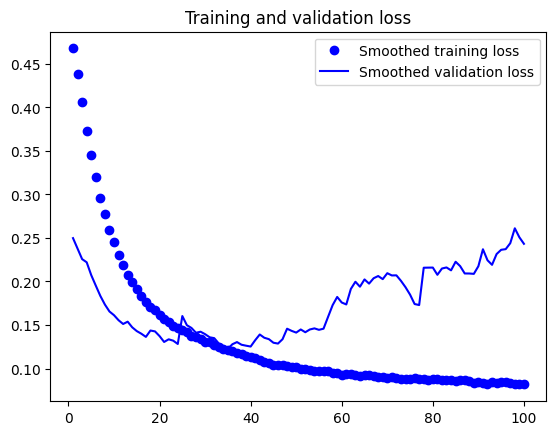

In [10]:
# 平滑曲线函数
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
# 在验证集上面进行测试
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)
test_loss, test_acc = model.evaluate(test_generator, steps=2500 // 32)

Found 12461 images belonging to 2 classes.
78/78 [==============================] - 3s 36ms/step - loss: 0.1674 - accuracy: 0.9643
